In [25]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import random
import pandas as pd
import yaml

from argparse import Namespace

import numpy as np
import networkx as nx
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

root_dir = os.path.dirname(
        os.path.dirname(os.path.realpath(".")))

sys.path.append(root_dir)


import logging

from rl_envs_forge.envs.grid_world.grid_world import GridWorld
from common.src.distribution_src import make_env, randomize_walls_positions, generate_train_test_split_with_valid_path
from common.src.dqn.my_dqn import AgentDQN

from common.src.experiment_utils import (
    setup_logger,
    convert_from_string,
    namespace_to_dict,
)

from argparse import Namespace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[(2, 0), (1, 2)]


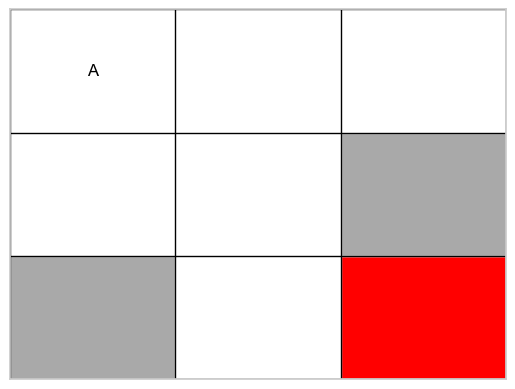

In [19]:
terminal_states = {(2, 2): 1}
start_state = (0, 0)
rows = 3
cols = 3
seed = 2

# random_walls = randomize_walls_positions(rows, cols, start_state, terminal_states, 0.2, seed=seed)
random_walls = [(2, 0), (1, 2)]
print(random_walls)
env = make_env(rows, cols, start_state=start_state, p_success=1, terminal_states=terminal_states, seed=seed, walls=random_walls)
env.render()


In [20]:
env.mdp

{((0, 0), <Action.UP: 0>): [((0, 0), 0, False, 1)],
 ((0, 0), <Action.RIGHT: 1>): [((0, 1), 0, False, 1)],
 ((0, 0), <Action.DOWN: 2>): [((1, 0), 0, False, 1)],
 ((0, 0), <Action.LEFT: 3>): [((0, 0), 0, False, 1)],
 ((0, 1), <Action.UP: 0>): [((0, 1), 0, False, 1)],
 ((0, 1), <Action.RIGHT: 1>): [((0, 2), 0, False, 1)],
 ((0, 1), <Action.DOWN: 2>): [((1, 1), 0, False, 1)],
 ((0, 1), <Action.LEFT: 3>): [((0, 0), 0, False, 1)],
 ((0, 2), <Action.UP: 0>): [((0, 2), 0, False, 1)],
 ((0, 2), <Action.RIGHT: 1>): [((0, 2), 0, False, 1)],
 ((0, 2), <Action.DOWN: 2>): [((0, 2), 0, False, 1)],
 ((0, 2), <Action.LEFT: 3>): [((0, 1), 0, False, 1)],
 ((1, 0), <Action.UP: 0>): [((0, 0), 0, False, 1)],
 ((1, 0), <Action.RIGHT: 1>): [((1, 1), 0, False, 1)],
 ((1, 0), <Action.DOWN: 2>): [((1, 0), 0, False, 1)],
 ((1, 0), <Action.LEFT: 3>): [((1, 0), 0, False, 1)],
 ((1, 1), <Action.UP: 0>): [((0, 1), 0, False, 1)],
 ((1, 1), <Action.RIGHT: 1>): [((1, 1), 0, False, 1)],
 ((1, 1), <Action.DOWN: 2>): [((2

In [21]:
ts = next(iter(terminal_states))

for trial in range(100000):
    random_walls = randomize_walls_positions(rows, cols, start_state, terminal_states, 0.2, seed=trial)

    if (start_state in random_walls) or (ts in random_walls):
        raise ValueError("start state or terminal state in walls")

    

In [22]:
transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]

transitions_train, transitions_val = generate_train_test_split_with_valid_path(
        transitions_list=transitions_list,
        start_state=start_state,
        terminal_states=terminal_states,
)
        

In [27]:
### Setup output and loading paths ###
file_path = r'results\2024May07-003612_configs\0000_tau_0.001\0\cfg.yaml'

# Open the YAML file and load its content into a dictionary
with open(file_path, 'r') as file:
    data = yaml.safe_load(file)
    
opts = Namespace(**data)

opts.seed = random.randint(0, 2**32 - 1) if opts.seed is None else opts.seed
opts.start_state = convert_from_string(opts.start_state)
opts.terminal_states = namespace_to_dict(opts.terminal_states)
config = vars(opts)

config

{'agent_params': {'agent': 'AgentDQN',
  'args_': {'batch_size': 32,
   'epsilon': {'decay': 250000, 'end': 0.01, 'start': 1.0},
   'gamma': 0.99,
   'loss_fcn': 'mse_loss',
   'replay_start_size': 5000,
   'target_model_update_freq': 4000,
   'train_step_cnt': 200000,
   'training_freq': 4,
   'validation_enabled': True,
   'validation_epsilon': 0.001,
   'validation_step_cnt': 125000}},
 'alpha': 0.1,
 'batch_size': 32,
 'cfg_id': 0,
 'cols': 10,
 'epsilon': 0.01,
 'estimator': {'args_': {'conv_hidden_out_size': 32,
   'lin_hidden_out_size': 128},
  'model': 'Conv_QNET'},
 'experiment': 'experiment_distributions',
 'experiment_arguments': {'tau': 0.001},
 'full_title': '2024May07-003612_configs_tau=0.001',
 'gamma': 0.9,
 'min_samples': 10,
 'neural_fit_mode': 'mean',
 'num_steps': 40000,
 'optim': {'args_': {'eps': 0.0003125, 'lr': 0.00025}, 'name': 'Adam'},
 'out_dir': '.\\results\\2024May07-003612_configs\\0000_tau_0.001\\0',
 'p_success': 1,
 'redo': {'attach': False,
  'beta': 1

In [28]:
p_success = 1
train_env = env = make_env(rows, cols, start_state, p_success, terminal_states, seed)
validation_env = env = make_env(rows, cols, start_state, p_success, terminal_states, seed)


experiment_agent = AgentDQN(
    train_env=train_env,
    validation_env=validation_env,
    experiment_output_folder=config["out_dir"],
    experiment_name=config["experiment"],
    resume_training_path=None,
    save_checkpoints=True,
    logger=None,
    config=config,
    enable_tensorboard_logging=False,
)

# experiment_agent.train(train_epochs=config["epochs_to_train"])

TypeError: 'NoneType' object is not subscriptable